In [55]:
import pandas as pd
import numpy as np

In [155]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
                "hours-per-week", "native-country", "income"]

data = pd.read_csv(url, names=column_names, sep=',\s', engine='python')

data = data.replace('?', np.nan).dropna()
sample_size = 5000
data_sample = data.sample(n=sample_size, random_state=42)

X = data_sample.drop("income", axis=1)
# X = data_sample.drop("fnlwgt", axis=1)

y = data_sample["income"]

y = y.apply(lambda x: 1 if x == ">50K" else 0)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n9/30zygwt11sx45tbs2qhkwxtw0000gn/T/ipykernel_48619/3228734479.py:6: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(url, names=column_names, sep=',\s', engine='python')


In [156]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

In [157]:
import torch
X_tensor = torch.tensor(X_processed.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

In [158]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [162]:
from torch import nn
class IPNN(nn.Module):
    def __init__(self):
        super(IPNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [163]:
import torch.optim as optim
model = IPNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [164]:
num_epochs = 25
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_test_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")


Epoch 1/25, Train Loss: 0.5261, Train Accuracy: 70.55%, Test Loss: 0.3739, Test Accuracy: 82.40%
Epoch 2/25, Train Loss: 0.3625, Train Accuracy: 83.25%, Test Loss: 0.3550, Test Accuracy: 83.70%
Epoch 3/25, Train Loss: 0.3437, Train Accuracy: 84.35%, Test Loss: 0.3493, Test Accuracy: 83.10%
Epoch 4/25, Train Loss: 0.3332, Train Accuracy: 84.38%, Test Loss: 0.3444, Test Accuracy: 83.70%
Epoch 5/25, Train Loss: 0.3256, Train Accuracy: 86.08%, Test Loss: 0.3427, Test Accuracy: 83.00%
Epoch 6/25, Train Loss: 0.3229, Train Accuracy: 85.72%, Test Loss: 0.3420, Test Accuracy: 83.60%
Epoch 7/25, Train Loss: 0.3154, Train Accuracy: 85.70%, Test Loss: 0.3471, Test Accuracy: 83.40%
Epoch 8/25, Train Loss: 0.3158, Train Accuracy: 86.05%, Test Loss: 0.3463, Test Accuracy: 82.60%
Epoch 9/25, Train Loss: 0.3145, Train Accuracy: 85.70%, Test Loss: 0.3446, Test Accuracy: 83.00%
Epoch 10/25, Train Loss: 0.3149, Train Accuracy: 86.00%, Test Loss: 0.3412, Test Accuracy: 83.00%
Epoch 11/25, Train Loss: 0.30

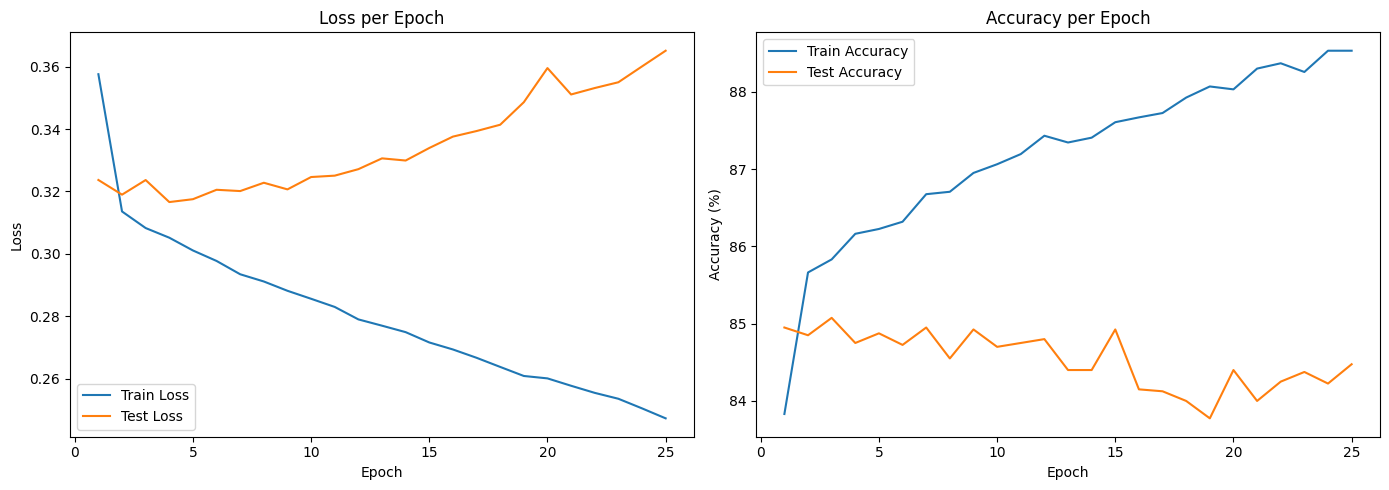

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


# SVM

In [170]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(kernel='linear', C=1.1)
svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification Report for Test Set:\n")
print(classification_report(y_train, y_train_pred))


/Users/xiaoyangchen/miniconda3/envs/ML/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.86
Test Accuracy: 0.84

Classification Report for Test Set:

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      3000
         1.0       0.77      0.62      0.69      1000

    accuracy                           0.86      4000
   macro avg       0.83      0.78      0.80      4000
weighted avg       0.85      0.86      0.85      4000



In [171]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       748
         1.0       0.72      0.58      0.65       252

    accuracy                           0.84      1000
   macro avg       0.80      0.75      0.77      1000
weighted avg       0.83      0.84      0.83      1000



# KNN 

In [175]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train, y_train)

y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification Report for Test Set:\n")
print(classification_report(y_test, y_test_pred))

# Plotting the accuracy
labels = ['Train Accuracy', 'Test Accuracy']
values = [train_accuracy, test_accuracy]


Train Accuracy: 0.86
Test Accuracy: 0.83

Classification Report for Test Set:

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89       748
         1.0       0.69      0.57      0.62       252

    accuracy                           0.83      1000
   macro avg       0.77      0.74      0.76      1000
weighted avg       0.82      0.83      0.82      1000



/Users/xiaoyangchen/miniconda3/envs/ML/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
